##Загрузка необходимых библиотек и методов

In [ ]:
!pip install prophet ta --quiet

  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from ta.momentum import RSIIndicator
from ta.trend import MACD
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error

##Загрузка и предобработка данных

In [ ]:
df = pd.read_json("sber.json")
df.head()

,date,close,open,low,high,trendclspr,volume,value,numtrades
0,2022-03-28,125.00,130.60,125.00,131.47,-4.94,33212430,4.203875e+09,121793
1,2022-03-29,128.77,126.16,122.00,137.57,3.02,72338740,9.470337e+09,184608
2,2022-03-30,134.60,136.89,131.11,138.40,4.53,35675450,4.754054e+09,102479
3,2022-03-31,143.69,135.25,134.52,147.41,6.75,118425000,1.666945e+10,255603
4,2022-04-01,154.50,145.00,144.51,155.40,7.52,118880720,1.802233e+10,265276


In [ ]:
df = df.rename(columns={'date': 'ds', 'close': 'y'})
df = df.sort_values('ds')
df = df.reset_index(drop=True)
df.head()

,ds,y,open,low,high,trendclspr,volume,value,numtrades
0,2022-03-28,125.00,130.60,125.00,131.47,-4.94,33212430,4.203875e+09,121793
1,2022-03-29,128.77,126.16,122.00,137.57,3.02,72338740,9.470337e+09,184608
2,2022-03-30,134.60,136.89,131.11,138.40,4.53,35675450,4.754054e+09,102479
3,2022-03-31,143.69,135.25,134.52,147.41,6.75,118425000,1.666945e+10,255603
4,2022-04-01,154.50,145.00,144.51,155.40,7.52,118880720,1.802233e+10,265276


In [ ]:
# Временные признаки
df['dayofweek'] = df['ds'].dt.dayofweek
df['month'] = df['ds'].dt.month
df['day'] = df['ds'].dt.day
df['day_of_year'] = df['ds'].dt.dayofyear

df = df.dropna()
df.head()

,ds,y,open,low,high,trendclspr,volume,value,numtrades,dayofweek,month,day,day_of_year
0,2022-03-28,125.00,130.60,125.00,131.47,-4.94,33212430,4.203875e+09,121793,0,3,28,87
1,2022-03-29,128.77,126.16,122.00,137.57,3.02,72338740,9.470337e+09,184608,1,3,29,88
2,2022-03-30,134.60,136.89,131.11,138.40,4.53,35675450,4.754054e+09,102479,2,3,30,89
3,2022-03-31,143.69,135.25,134.52,147.41,6.75,118425000,1.666945e+10,255603,3,3,31,90
4,2022-04-01,154.50,145.00,144.51,155.40,7.52,118880720,1.802233e+10,265276,4,4,1,91


In [ ]:
test_size = int(len(df) * 0.2)
df_train = df.iloc[:-test_size].copy()
df_test = df.iloc[-test_size:].copy()

df_train['returns'] = df_train['y'].pct_change()
df_train['rsi'] = RSIIndicator(close=df_train['y']).rsi()
macd_train = MACD(close=df_train['y'])
df_train['macd'] = macd_train.macd_diff()
df_train = df_train.dropna().drop_duplicates()
df_train.head()

,ds,y,open,low,high,trendclspr,volume,value,numtrades,dayofweek,month,day,day_of_year,returns,rsi,macd
33,2022-05-18,125.12,-1.483412,-1.496276,-1.470846,-1.158266,0.153319,-0.565467,0.345239,-0.009244,-0.468832,0.235173,-0.458962,-0.020587,49.094619,0.547198
34,2022-05-19,125.60,-1.525724,-1.522541,-1.535802,0.134431,-0.529302,-0.975863,-0.383938,0.694600,-0.468832,0.350012,-0.449457,0.003836,49.589350,0.631546
35,2022-05-20,122.20,-1.514743,-1.554235,-1.533754,-1.502632,-0.367872,-0.894060,-0.128540,1.398443,-0.468832,0.464852,-0.439951,-0.027070,46.166743,0.453684
36,2022-05-23,119.46,-1.581506,-1.585783,-1.599587,-1.253629,-0.409883,-0.932167,-0.154091,-1.416930,-0.468832,0.809370,-0.411433,-0.022422,43.557651,0.161883
37,2022-05-24,123.60,-1.611520,-1.612194,-1.563013,1.771495,-0.179712,-0.806239,0.042159,-0.713087,-0.468832,0.924209,-0.401928,0.034656,48.310931,0.252660


In [ ]:
last_n = 35
df_hist = df_train.iloc[-last_n:].copy()
df_test_full = pd.concat([df_hist, df_test], ignore_index=True)

df_test_full['returns'] = df_test_full['y'].pct_change()
df_test_full['rsi'] = RSIIndicator(close=df_test_full['y']).rsi()
macd_test = MACD(close=df_test_full['y'])
df_test_full['macd'] = macd_test.macd_diff()

df_test = df_test_full.iloc[last_n:].copy()
df_test = df_test.dropna().drop_duplicates()
df_test_tail = df_test.tail(48)
df_test_tail.head()

,ds,y,open,low,high,trendclspr,volume,value,numtrades,dayofweek,month,day,day_of_year,returns,rsi,macd
200,2025-01-28,278.35,0.669548,0.690171,0.693760,0.531777,-0.376116,-0.039608,-0.588052,-0.713087,-1.629075,1.383567,-1.504600,0.000000,51.983355,-1.073382
201,2025-01-29,280.36,0.709810,0.735805,0.736478,0.314561,-0.371927,-0.017765,-0.520124,-0.009244,-1.629075,1.498406,-1.495094,0.007221,56.644662,-0.824269
202,2025-01-29,280.36,0.709810,0.735805,0.736478,0.314561,-0.371927,-0.017765,-0.520124,-0.009244,-1.629075,1.498406,-1.495094,0.000000,56.644662,-0.642420
203,2025-01-30,281.97,0.745535,0.783346,0.741160,0.235092,-0.728641,-0.459621,-0.786606,0.694600,-1.629075,1.613245,-1.485589,0.005743,60.231065,-0.408052
204,2025-01-30,281.97,0.745535,0.783346,0.741160,0.235092,-0.728641,-0.459621,-0.786606,0.694600,-1.629075,1.613245,-1.485589,0.000000,60.231065,-0.254869


In [ ]:
regressors = ['open', 'low', 'high', 'trendclspr', 'volume', 'value', 'numtrades',
              'dayofweek', 'month', 'day', 'day_of_year']

scaler = StandardScaler()
df[regressors] = scaler.fit_transform(df[regressors])

##Тест вручуную настраиваемой модели для экспериментов

In [ ]:
# model = Prophet(seasonality_mode='additive',
#     changepoint_prior_scale = 0.001,
#     seasonality_prior_scale=0.001,
#     weekly_seasonality=True,
#     daily_seasonality=True)
# model.add_regressor('returns')
# model.add_regressor('rsi')
# model.add_regressor('macd')

# for reg in regressors:
#     model.add_regressor(reg)

# model.fit(df_train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpp8otj7z4/ldwybtwy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp8otj7z4/17jqf582.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22808', 'data', 'file=/tmp/tmpp8otj7z4/ldwybtwy.json', 'init=/tmp/tmpp8otj7z4/17jqf582.json', 'output', 'file=/tmp/tmpp8otj7z4/prophet_modeliubg6pj7/prophet_model-20250410043731.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:37:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:37:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


##Автоматический подбор параметров для лучшей (по MSE) модели
Эта ячейка раньше была внизу, поэтому от её исполнения хвост output-ов там.

In [ ]:
from prophet.diagnostics import performance_metrics
from itertools import product
from concurrent.futures import ProcessPoolExecutor, as_completed


# Сетка параметров
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.001, 0.005, 0.0001],
    'seasonality_prior_scale': [0.01, 0.001, 0.005, 0.0001],
    'weekly_seasonality': [True],
    'daily_seasonality': [True]
}
all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

def train_and_evaluate(params):
    try:
        model = Prophet(**params)
        model.add_regressor('returns')
        model.add_regressor('rsi')
        model.add_regressor('macd')
        for reg in regressors:
            model.add_regressor(reg)
        model.fit(df_train)
        future = df_test_tail[['ds', 'returns', 'rsi', 'macd'] + regressors]
        forecast = model.predict(future)
        mse = mean_squared_error(df_test_tail['y'].values, forecast['yhat'].values)
        return {'params': params, 'mse': mse}
    except Exception as e:
        return {'params': params, 'mse': np.inf, 'error': str(e)}

results = []
with ProcessPoolExecutor() as executor:
    futures = [executor.submit(train_and_evaluate, p) for p in all_params]
    for future in as_completed(futures):
        results.append(future.result())

results = sorted(results, key=lambda x: x['mse'])
best = results[0]
print("Лучшие параметры:", best['params'])
print(f"MSE: {best['mse']:.4f}")

In [ ]:
model = Prophet(**best['params'])
model.add_regressor('returns')
model.add_regressor('rsi')
model.add_regressor('macd')

for reg in regressors:
    model.add_regressor(reg)

model.fit(df_train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpp8otj7z4/_vxt_k7l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp8otj7z4/f6vjnfas.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38152', 'data', 'file=/tmp/tmpp8otj7z4/_vxt_k7l.json', 'init=/tmp/tmpp8otj7z4/f6vjnfas.json', 'output', 'file=/tmp/tmpp8otj7z4/prophet_model_adqkrs4/prophet_model-20250410044329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:43:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:43:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


##Предсказание и визуализация


Метрики:
MSE: 1.538
MAE: 0.994
RMSE: 1.240
R²: 0.994
MAPE: 0.003


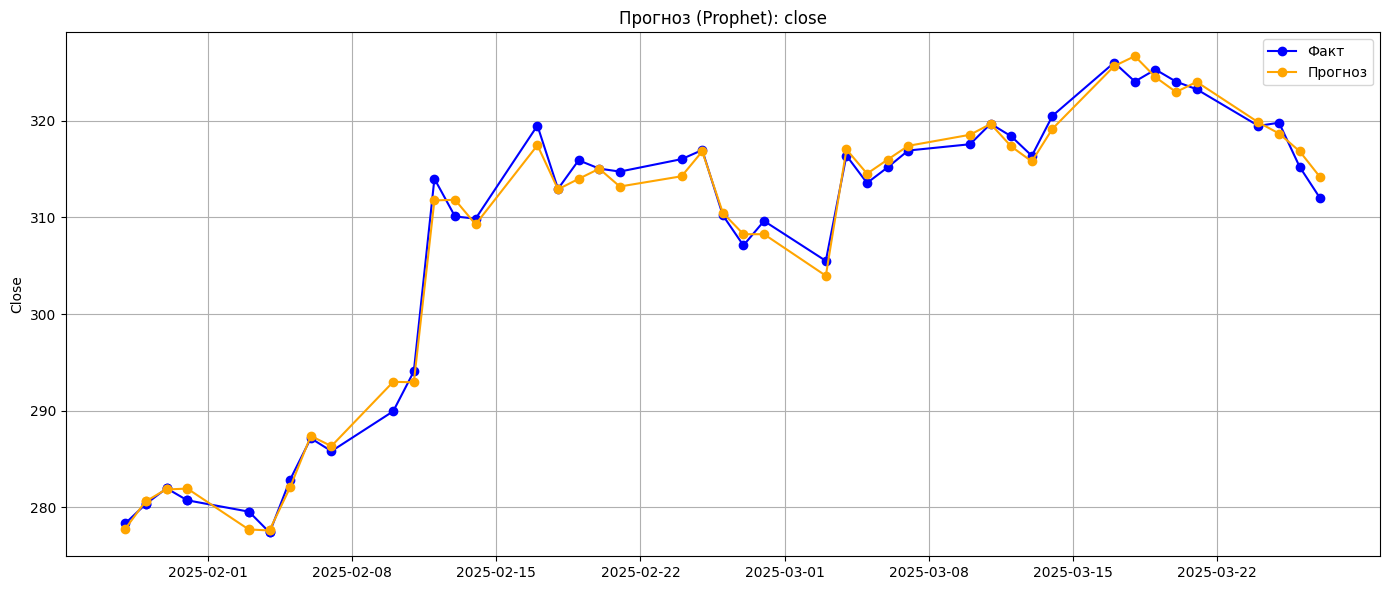

In [ ]:
future = df_test_tail[['ds', 'returns', 'rsi', 'macd'] + regressors]
forecast = model.predict(future)

mse = mean_squared_error(df_test_tail['y'], forecast['yhat'])
mae = mean_absolute_error(df_test_tail['y'], forecast['yhat'])
rmse = np.sqrt(mse)
r2 = r2_score(df_test_tail['y'], forecast['yhat'])
mape = mean_absolute_percentage_error(df_test_tail['y'], forecast['yhat'])
print(f"\nМетрики:")
print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")
print(f"MAPE: {mape:.3f}")

plt.figure(figsize=(14, 6))
plt.plot(df_test_tail['ds'], df_test_tail['y'], label='Факт', marker='o', color='blue')
plt.plot(df_test_tail['ds'], forecast['yhat'], label='Прогноз', marker='o', color='orange')

plt.title('Прогноз (Prophet): close')
plt.ylabel('Close')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpp8otj7z4/we3ded9i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp8otj7z4/hd1ily4u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp8otj7z4/33xjarzw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp8otj7z4/s_yecrc_.json
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53408', 'data', 'file=/tmp/tmpp8otj7z4/we3ded9i.json', 'init=/tmp/tmpp8otj7z4/33xjarzw.json', 'output', 'file=/tmp/tmpp8otj7z4/prophet_modelgy4qe1m5/prophet_model-20250410044118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:41:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56523', 'data

Лучшие параметры: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.001, 'weekly_seasonality': True, 'daily_seasonality': True}
MSE: 1.5380
